In [ ]:
### Imports

import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

## 0. Data Visualization

In [3]:
df = pd.read_csv('../DL-2025-CW-data/Data_A.csv', names=['target', 'lvl1_sell_p', 'lvl1_sell_vol', 'lvl1_buy_p', 'lvl1_buy_vol', 'lvl2_sell_p', 'lvl2_sell_vol', 'lvl2_buy_p', 'lvl2_buy_vol', 'lvl3_sell_p', 'lvl3_sell_vol', 'lvl3_buy_p', 'lvl3_buy_vol', 'lvl4_sell_p', 'lvl4_sell_vol', 'lvl4_buy_p', 'lvl4_buy_vol', 'prev_midprice1', 'prev_midprice2', 'prev_midprice3', 'prev_midprice4', 'prev_midprice5'])
df.head()

,target,lvl1_sell_p,lvl1_sell_vol,lvl1_buy_p,lvl1_buy_vol,lvl2_sell_p,lvl2_sell_vol,lvl2_buy_p,lvl2_buy_vol,lvl3_sell_p,...,lvl3_buy_vol,lvl4_sell_p,lvl4_sell_vol,lvl4_buy_p,lvl4_buy_vol,prev_midprice1,prev_midprice2,prev_midprice3,prev_midprice4,prev_midprice5
0,1,693200.0,126,692800.0,110,693300.0,50,692700.0,165,693400.0,...,50,693500.0,50,692500.0,250,0,1,0,1,0
1,0,650400.0,501,650200.0,106,650500.0,245,650100.0,259,650600.0,...,328,650700.0,141,649900.0,277,0,0,1,1,1
2,1,636200.0,153,635800.0,150,636300.0,100,635700.0,15,636400.0,...,110,636500.0,105,635500.0,201,0,1,0,1,0
3,0,724800.0,4,724500.0,14,724900.0,50,724300.0,312,725100.0,...,100,725200.0,379,724100.0,56,1,0,0,1,1
4,0,622900.0,110,622700.0,100,623000.0,523,622600.0,300,623100.0,...,249,623200.0,605,622400.0,200,1,0,1,1,0


In [4]:
print("midprice1", df[df["prev_midprice1"] == 1]["target"].mean())
print("midprice2", df[df["prev_midprice2"] == 1]["target"].mean())
print("midprice3", df[df["prev_midprice3"] == 1]["target"].mean())
print("midprice4", df[df["prev_midprice4"] == 1]["target"].mean())
print("midprice5", df[df["prev_midprice5"] == 1]["target"].mean())

midprice1 0.44016393442622953
midprice2 0.5607289066400399
midprice3 0.4568312995546324
midprice4 0.5470340084371313
midprice5 0.47228441210570504


mean reversion -> ok d'après ci dessus

In [5]:
df["obi"] = (df['lvl1_buy_vol'] - df['lvl1_sell_vol']) / (df['lvl1_buy_vol'] + df['lvl1_sell_vol'])
df["obi_2"] = (df['lvl2_buy_vol'] + df['lvl1_buy_vol'] - df['lvl2_sell_vol'] - df['lvl1_sell_vol']) / (df['lvl2_buy_vol'] + df['lvl1_buy_vol'] + df['lvl2_sell_vol'] + df['lvl1_sell_vol'])
df["obi_3"] = (df['lvl3_buy_vol'] + df['lvl2_buy_vol'] + df['lvl1_buy_vol'] - df['lvl3_sell_vol'] - df['lvl2_sell_vol'] - df['lvl1_sell_vol']) / (df['lvl3_buy_vol'] + df['lvl2_buy_vol'] + df['lvl1_buy_vol'] + df['lvl3_sell_vol'] + df['lvl2_sell_vol'] + df['lvl1_sell_vol'])
df["obi_4"] = (df['lvl4_buy_vol'] + df['lvl3_buy_vol'] + df['lvl2_buy_vol'] + df['lvl1_buy_vol'] - df['lvl4_sell_vol'] - df['lvl3_sell_vol'] - df['lvl2_sell_vol'] - df['lvl1_sell_vol']) / (df['lvl4_buy_vol'] + df['lvl3_buy_vol'] + df['lvl2_buy_vol'] + df['lvl1_buy_vol'] + df['lvl4_sell_vol'] + df['lvl3_sell_vol'] + df['lvl2_sell_vol'] + df['lvl1_sell_vol'])

In [6]:
df["spread"] = df['lvl1_sell_p'] - df['lvl1_buy_p']

In [7]:
df[df["spread"] > 50000]

,target,lvl1_sell_p,lvl1_sell_vol,lvl1_buy_p,lvl1_buy_vol,lvl2_sell_p,lvl2_sell_vol,lvl2_buy_p,lvl2_buy_vol,lvl3_sell_p,...,prev_midprice1,prev_midprice2,prev_midprice3,prev_midprice4,prev_midprice5,obi,obi_2,obi_3,obi_4,spread
149186,1,512600.0,100,453300.0,700,517900.0,200,452900.0,500,520000.0,...,1,1,1,0,0,0.75,0.6,0.712655,0.770417,59300.0


In [8]:
df.sort_values("lvl1_sell_p", ascending=False).head(10)

,target,lvl1_sell_p,lvl1_sell_vol,lvl1_buy_p,lvl1_buy_vol,lvl2_sell_p,lvl2_sell_vol,lvl2_buy_p,lvl2_buy_vol,lvl3_sell_p,...,prev_midprice1,prev_midprice2,prev_midprice3,prev_midprice4,prev_midprice5,obi,obi_2,obi_3,obi_4,spread
65336,0,1018400.0,331,1016000.0,100,1018500.0,300,1015400.0,20,1018900.0,...,0,1,1,1,1,-0.535963,-0.680426,-0.431472,-0.360807,2400.0
39852,0,1017900.0,463,1014700.0,100,1018000.0,36,1014600.0,1,1018400.0,...,0,1,0,0,1,-0.644760,-0.663333,-0.661692,-0.552972,3200.0
50402,0,1017500.0,380,1015600.0,60,1017600.0,200,1014900.0,2,1017700.0,...,0,0,1,0,1,-0.727273,-0.806854,-0.822285,-0.820728,1900.0
53105,0,1016800.0,209,1014600.0,1,1016900.0,261,1014500.0,2,1017000.0,...,0,1,1,1,0,-0.990476,-0.987315,-0.803005,-0.823077,2200.0
39708,1,1016000.0,100,1015200.0,30,1016500.0,100,1015000.0,38,1016900.0,...,0,0,1,1,0,-0.538462,-0.492537,-0.575758,-0.788690,800.0
84620,1,1015900.0,1,1013700.0,13,1016300.0,33,1013600.0,8,1016400.0,...,0,1,1,1,1,0.857143,-0.236364,-0.472222,0.045455,2200.0
74657,1,1015300.0,100,1014400.0,2,1015400.0,43,1013600.0,10,1015800.0,...,0,0,0,0,0,-0.960784,-0.845161,-0.593525,-0.692105,900.0
36367,1,1014400.0,39,1012600.0,1,1015000.0,142,1012300.0,220,1015900.0,...,1,1,0,0,0,-0.950000,0.099502,0.099010,0.104265,1800.0
21500,0,1014200.0,100,1011300.0,55,1014400.0,10,1011200.0,20,1015000.0,...,1,1,0,1,0,-0.290323,-0.189189,-0.327434,-0.309237,2900.0
70002,1,1014000.0,11,1011600.0,12,1014200.0,100,1011500.0,21,1014400.0,...,1,1,1,0,0,0.043478,-0.541667,-0.709402,-0.383285,2400.0


In [9]:
df["spread"].median()

np.float64(200.0)

<Axes: >

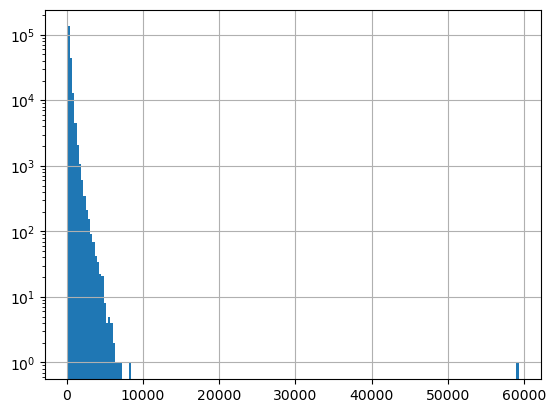

In [10]:
df["spread"].hist(bins=200, log=True)


(0.0, 1000.0)

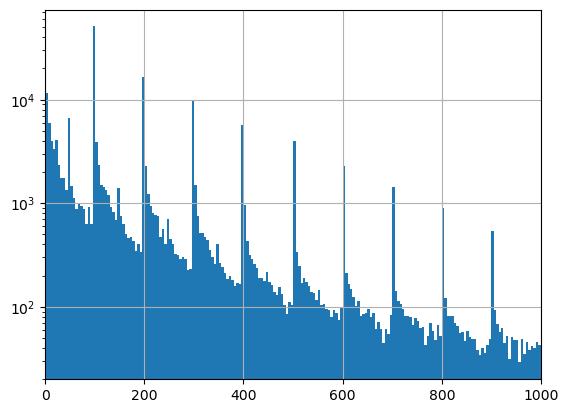

In [11]:
df[df["lvl1_buy_vol"] < 1000]["lvl1_buy_vol"].hist(bins=200, log=True)
plt.xlim(0, 1000)

[]

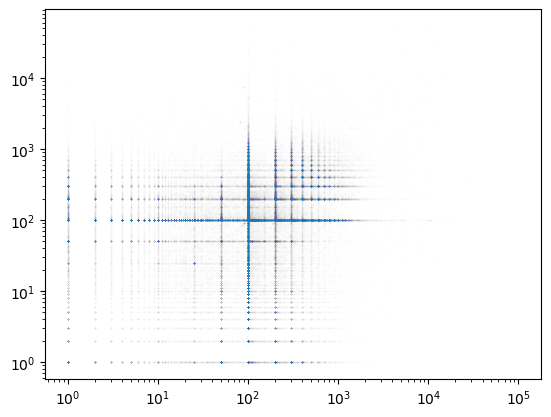

In [12]:
plt.scatter(df["lvl1_buy_vol"], df["lvl1_sell_vol"], alpha=0.01, s=0.1)
plt.loglog()

In [13]:
df[df["obi"] == 0.5]

,target,lvl1_sell_p,lvl1_sell_vol,lvl1_buy_p,lvl1_buy_vol,lvl2_sell_p,lvl2_sell_vol,lvl2_buy_p,lvl2_buy_vol,lvl3_sell_p,...,prev_midprice1,prev_midprice2,prev_midprice3,prev_midprice4,prev_midprice5,obi,obi_2,obi_3,obi_4,spread
234,1,624400.0,50,624100.0,150,624500.0,100,624000.0,227,624600.0,...,0,1,1,1,1,0.5,0.430740,0.277978,0.102679,300.0
504,0,786200.0,1,785700.0,3,786300.0,1,785600.0,29,786400.0,...,1,1,1,1,1,0.5,0.882353,0.944444,0.326861,500.0
517,1,622800.0,43,622500.0,129,622900.0,139,622400.0,165,623000.0,...,1,0,0,0,1,0.5,0.235294,0.204878,0.222520,300.0
564,1,730600.0,1,730200.0,3,730700.0,101,730100.0,204,730800.0,...,0,1,0,0,0,0.5,0.339806,-0.414909,-0.394022,400.0
602,1,620800.0,100,619400.0,300,622200.0,69,619300.0,101,622400.0,...,0,1,0,0,1,0.5,0.407018,0.325213,0.319005,1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199833,0,416900.0,100,416600.0,300,417000.0,100,416500.0,451,417300.0,...,1,0,1,1,0,0.5,0.579390,0.478714,0.428898,300.0
199850,1,507200.0,100,507100.0,300,507600.0,600,507000.0,200,507700.0,...,0,1,1,1,0,0.5,-0.166667,-0.272727,-0.172414,100.0
199868,1,505000.0,100,504800.0,300,505100.0,100,504700.0,300,505200.0,...,1,0,1,0,1,0.5,0.500000,0.538462,0.090909,200.0
199901,1,503500.0,100,503200.0,300,503600.0,400,503100.0,422,503700.0,...,1,1,1,1,1,0.5,0.181669,0.437473,0.402628,300.0


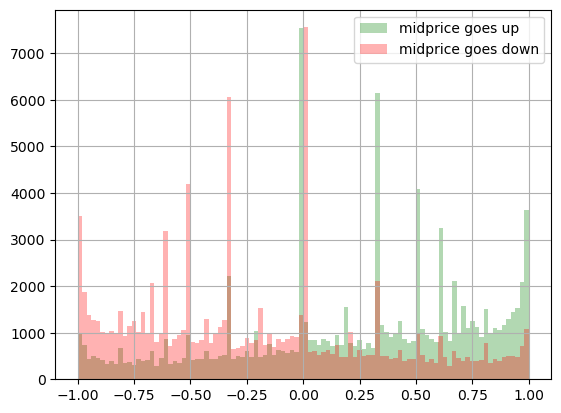

In [14]:
df[df["target"] == 1]["obi"].hist(alpha=0.3, color='g', bins=100, label='midprice goes up')
df[df["target"] == 0]["obi"].hist(alpha=0.3, color='r', bins=100, label='midprice goes down')
plt.legend()

on remarque eu l'obi est en moyenne un bon indicateur (66% d'accuracy) du midprice change
quelques valeurs étonnantes -> correspondent aux multiples de 100 dans l'order book 

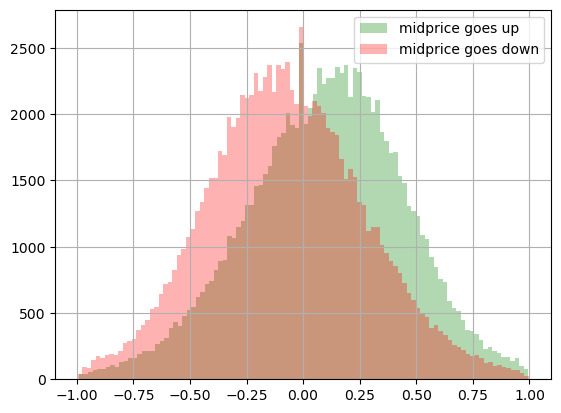

In [15]:
df[df["target"] == 1]["obi_3"].hist(alpha=0.3, color='g', bins=100, label='midprice goes up')
df[df["target"] == 0]["obi_3"].hist(alpha=0.3, color='r', bins=100, label='midprice goes down')
plt.legend()

In [16]:
bid_orders = df.loc[1,:].filter(like='buy_p')
ask_orders = df.loc[1,:].filter(like='sell_p')
bid_vol = df.loc[1,:].filter(like='buy_vol')
ask_vol = df.loc[1,:].filter(like='sell_vol')

# 1. Feature Engineering

midprice
depth = total volume de chaque cote
price gaps: ecarts entre les niveaux 

In [17]:
df.head()

,target,lvl1_sell_p,lvl1_sell_vol,lvl1_buy_p,lvl1_buy_vol,lvl2_sell_p,lvl2_sell_vol,lvl2_buy_p,lvl2_buy_vol,lvl3_sell_p,...,prev_midprice1,prev_midprice2,prev_midprice3,prev_midprice4,prev_midprice5,obi,obi_2,obi_3,obi_4,spread
0,1,693200.0,126,692800.0,110,693300.0,50,692700.0,165,693400.0,...,0,1,0,1,0,-0.067797,0.219512,-0.119241,0.107900,400.0
1,0,650400.0,501,650200.0,106,650500.0,245,650100.0,259,650600.0,...,0,0,1,1,1,-0.650741,-0.342934,-0.126654,-0.032419,200.0
2,1,636200.0,153,635800.0,150,636300.0,100,635700.0,15,636400.0,...,0,1,0,1,0,-0.009901,-0.210526,-0.188791,-0.032520,400.0
3,0,724800.0,4,724500.0,14,724900.0,50,724300.0,312,725100.0,...,1,0,0,1,1,0.555556,0.715789,0.352381,-0.094836,300.0
4,0,622900.0,110,622700.0,100,623000.0,523,622600.0,300,623100.0,...,1,0,1,1,0,-0.047619,-0.225557,-0.245349,-0.327525,200.0


In [18]:
df["midprice"] = (df['lvl1_sell_p'] + df['lvl1_buy_p']) / 2
df["buy_depth"] = df['lvl1_buy_vol'] + df['lvl2_buy_vol'] + df['lvl3_buy_vol'] + df['lvl4_buy_vol']
df["sell_depth"] = df['lvl1_sell_vol'] + df['lvl2_sell_vol'] + df['lvl3_sell_vol'] + df['lvl4_sell_vol']
df["sell_price_gap_1"] = df['lvl2_sell_p'] - df['lvl1_sell_p']
df["sell_price_gap_2"] = df['lvl3_sell_p'] - df['lvl2_sell_p']
df["sell_price_gap_3"] = df['lvl4_sell_p'] - df['lvl3_sell_p']
df["buy_price_gap_1"] = df['lvl1_buy_p'] - df['lvl2_buy_p']
df["buy_price_gap_2"] = df['lvl2_buy_p'] - df['lvl3_buy_p']
df["buy_price_gap_3"] = df['lvl3_buy_p'] - df['lvl4_buy_p']
df["microprice"] = (df['lvl1_sell_p'] * df['lvl1_buy_vol'] + df['lvl1_buy_p'] * df['lvl1_sell_vol']) / (df['lvl1_sell_vol'] + df['lvl1_buy_vol'])

In [19]:
#momentum features
df["momentum"] = (2*(df["prev_midprice1"] + df["prev_midprice2"] + df["prev_midprice3"] + df["prev_midprice4"] + df["prev_midprice5"])-5)/5
df["momentum_sqr"] = (2*(df["prev_midprice1"] + df["prev_midprice2"] + df["prev_midprice3"] + df["prev_midprice4"] + df["prev_midprice5"])-5)**2
df["momentum_obi"] = df["momentum"] * df["obi"]

In [20]:
df.head()

,target,lvl1_sell_p,lvl1_sell_vol,lvl1_buy_p,lvl1_buy_vol,lvl2_sell_p,lvl2_sell_vol,lvl2_buy_p,lvl2_buy_vol,lvl3_sell_p,...,sell_price_gap_1,sell_price_gap_2,sell_price_gap_3,buy_price_gap_1,buy_price_gap_2,buy_price_gap_3,microprice,momentum,momentum_sqr,momentum_obi
0,1,693200.0,126,692800.0,110,693300.0,50,692700.0,165,693400.0,...,100.0,100.0,100.0,100.0,100.0,100.0,692986.440678,-0.2,1,0.013559
1,0,650400.0,501,650200.0,106,650500.0,245,650100.0,259,650600.0,...,100.0,100.0,100.0,100.0,100.0,100.0,650234.925865,0.2,1,-0.130148
2,1,636200.0,153,635800.0,150,636300.0,100,635700.0,15,636400.0,...,100.0,100.0,100.0,100.0,100.0,100.0,635998.019802,-0.2,1,0.001980
3,0,724800.0,4,724500.0,14,724900.0,50,724300.0,312,725100.0,...,100.0,200.0,100.0,200.0,100.0,100.0,724733.333333,0.2,1,0.111111
4,0,622900.0,110,622700.0,100,623000.0,523,622600.0,300,623100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,622795.238095,0.2,1,-0.009524


# 2. Training

In [ ]:
X = df.drop('target', axis=1)
y = df['target']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
#defining the FNN

class FNN(nn.Module):
    def __init__(self, input_dim, layer_sizes, hidden_activation, output_activation):
        super(FNN, self).__init__()
        layers = []
        prev_dim = input_dim
        for size in layer_sizes:
            layers.append(nn.Linear(prev_dim, size))
            layers.append(hidden_activation)
            prev_dim = size
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(output_activation)
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
def objective(trial):
    # Hyperparamètres
    n_layers = trial.suggest_int("n_layers", 1, 5)
    layer_sizes = [trial.suggest_int(f"n_neurons_l{i}", 8, 128) for i in range(n_layers)]
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)

    hidden_act_name = trial.suggest_categorical("hidden_activation", ["ReLU", "ELU", "PreLU"])
    output_act_name = trial.suggest_categorical("output_activation", ["Sigmoid", "TanH"])

    activation_dict = {
        "ReLU": nn.ReLU(),
        "Tanh": nn.Tanh(),
        "Sigmoid": nn.Sigmoid(),
        "ELU": nn.ELU(),
        "PreLU": nn.PReLU()
    }

    hidden_activation = activation_dict[hidden_act_name]
    output_activation = activation_dict[output_act_name]

    # K-Fold Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_losses = []

    for train_idx, val_idx in kf.split(X_train_full):
        X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
        y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]
    
        # DataLoader PyTorch
        train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train).unsqueeze(1))
        val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val).unsqueeze(1))

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32)

        model = FNN(input_dim=X.shape[1], layer_sizes=layer_sizes,
                    hidden_activation=hidden_activation, output_activation=output_activation)
        
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Early stopping
        best_val_loss = float('inf')
        patience = 10
        trigger_times = 0

        for epoch in range(100):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                pred = model(xb)
                loss = criterion(pred, yb)
                loss.backward()
                optimizer.step()
        
            # Validation
            model.eval()
            all_preds = []
            all_labels = []

            with torch.no_grad():
                for xb, yb in val_loader:
                    pred = model(xb)
                    pred_label = (pred > 0.5).float()  # convertir en 0/1
                    all_preds.append(pred_label)
                    all_labels.append(yb)

            all_preds = torch.cat(all_preds)
            all_labels = torch.cat(all_labels)

            accuracy = accuracy_score(all_labels.numpy(), all_preds.numpy())

            # Pour maximiser l'accuracy avec Optuna, retourner 1 - accuracy
            return 1 - accuracy

In [ ]:
# 1. Define an objective function to be maximized.
def objective(trial):

    n_layers = trial.suggest_int("n_layers", 1, 5)
    n_neurons = trial.suggest_int("n_neurons", 8, 128)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)
    activation_name = trial.suggest_categorical("activation", ["ReLU", "Tanh", "Sigmoid"])

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            early_stopping=True,
            solver=solver,
            alpha=alpha,
            learning_rate_init=learning_rate_init,
            max_iter=max_iter,
            random_state=42
        ))
    ])

    # Validation croisée pour évaluer l’accuracy moyenne
    score = cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy").mean()
    return score



In [38]:
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=4)

# --- 5. Afficher les meilleurs paramètres ---
print("Meilleurs hyperparamètres :", study.best_params)
print("Meilleure accuracy moyenne (CV) :", study.best_value)

# --- 6. Évaluer sur le jeu de test ---
best_params = study.best_params
hidden_layer_sizes = tuple(
    [best_params[f"n_units_l{i}"] for i in range(best_params["n_layers"])]
)

best_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=best_params["activation"],
        solver=best_params["solver"],
        alpha=best_params["alpha"],
        learning_rate_init=best_params["learning_rate_init"],
        max_iter=best_params["max_iter"],
        random_state=42
    ))
])

best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
print("Accuracy sur le test :", accuracy_score(y_test, y_pred))

Meilleurs hyperparamètres : {'n_layers': 4, 'n_units_l0': 91, 'n_units_l1': 76, 'n_units_l2': 81, 'n_units_l3': 31, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.015154787565502302, 'learning_rate_init': 0.002383150571677061, 'max_iter': 100}
Meilleure accuracy moyenne (CV) : 0.7172777777777778
Accuracy sur le test : 0.72665


sans plus de features

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df.iloc[:,1:21], df["target"], test_size=0.1, random_state=42)

In [25]:
# 1. Define an objective function to be maximized.
def objective2(trial):

    hidden_layer_sizes = tuple(
        [trial.suggest_int(f"n_units_l{i}", 10, 100) for i in range(trial.suggest_int("n_layers", 1, 5))]
    )
    activation = trial.suggest_categorical("activation", ["relu"])
    solver = trial.suggest_categorical("solver", ["adam"])
    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-3, 1e-2, log=True)
    max_iter = trial.suggest_int("max_iter", 50, 200, step=50)

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            early_stopping=True,
            solver=solver,
            alpha=alpha,
            learning_rate_init=learning_rate_init,
            max_iter=max_iter,
            random_state=42
        ))
    ])

    # Validation croisée pour évaluer l’accuracy moyenne
    score = cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy").mean()
    return score

,target,lvl1_sell_p,lvl1_sell_vol,lvl1_buy_p,lvl1_buy_vol,lvl2_sell_p,lvl2_sell_vol,lvl2_buy_p,lvl2_buy_vol,lvl3_sell_p,...,sell_price_gap_1,sell_price_gap_2,sell_price_gap_3,buy_price_gap_1,buy_price_gap_2,buy_price_gap_3,microprice,momentum,momentum_sqr,momentum_obi
0,1,693200.0,126,692800.0,110,693300.0,50,692700.0,165,693400.0,...,500.0,700.0,900.0,100.0,100.0,100.0,692986.440678,-0.2,1,0.013559
1,0,650400.0,501,650200.0,106,650500.0,245,650100.0,259,650600.0,...,300.0,500.0,700.0,100.0,100.0,100.0,650234.925865,0.2,1,-0.130148
2,1,636200.0,153,635800.0,150,636300.0,100,635700.0,15,636400.0,...,500.0,700.0,900.0,100.0,100.0,100.0,635998.019802,-0.2,1,0.001980
3,0,724800.0,4,724500.0,14,724900.0,50,724300.0,312,725100.0,...,400.0,800.0,1000.0,200.0,100.0,100.0,724733.333333,0.2,1,0.111111
4,0,622900.0,110,622700.0,100,623000.0,523,622600.0,300,623100.0,...,300.0,500.0,700.0,100.0,100.0,100.0,622795.238095,0.2,1,-0.009524


In [26]:
# 3. Create a study object and optimize the objective function.
study2 = optuna.create_study(direction='maximize')
study2.optimize(objective2, n_trials=100, n_jobs=4)

# --- 5. Afficher les meilleurs paramètres ---
print("Meilleurs hyperparamètres :", study2.best_params)
print("Meilleure accuracy moyenne (CV) :", study2.best_value)

# --- 6. Évaluer sur le jeu de test ---
best_params2 = study2.best_params
hidden_layer_sizes2 = tuple(
    [best_params[f"n_units_l{i}"] for i in range(best_params["n_layers"])]
)

best_clf2 = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes2,
        activation=best_params2["activation"],
        solver=best_params2["solver"],
        alpha=best_params2["alpha"],
        learning_rate_init=best_params2["learning_rate_init"],
        max_iter=best_params2["max_iter"],
        random_state=42
    ))
])

best_clf2.fit(X_train2, y_train2)
y_pred2 = best_clf2.predict(X_test2)
print("Accuracy sur le test :", accuracy_score(y_test2, y_pred2))

[I 2025-10-29 18:53:08,693] A new study created in memory with name: no-name-d52f412c-a525-4c8b-b36d-80f6696d0dcc
[I 2025-10-29 18:56:14,834] Trial 1 finished with value: 0.7144611111111111 and parameters: {'n_layers': 2, 'n_units_l0': 55, 'n_units_l1': 42, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001782922345821466, 'learning_rate_init': 0.00218523009975404, 'max_iter': 100}. Best is trial 1 with value: 0.7144611111111111.
[I 2025-10-29 18:56:22,515] Trial 2 finished with value: 0.7115055555555555 and parameters: {'n_layers': 2, 'n_units_l0': 27, 'n_units_l1': 96, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.010255828594279242, 'learning_rate_init': 0.008460963555420434, 'max_iter': 100}. Best is trial 1 with value: 0.7144611111111111.
[I 2025-10-29 18:56:33,547] Trial 3 finished with value: 0.7148222222222222 and parameters: {'n_layers': 3, 'n_units_l0': 41, 'n_units_l1': 35, 'n_units_l2': 44, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00018093661763503887, '

KeyboardInterrupt: 